# Fixed-Income Momentum Backtest



In [21]:
from src.data_request import BloombergAPI
from datetime import datetime
import pandas as pd
import numpy  as np

import warnings
warnings.filterwarnings('ignore')

index_specifications = {'TY1 Comdty':{'Symbol':'TY1 Comdty', 'Weight' : 1.0/8.0 , 'Vol_Scale_Cap':15.00},
                        'FV1 Comdty':{'Symbol':'FV1 Comdty', 'Weight' : 1.0/8.0 , 'Vol_Scale_Cap':15.00},
                        'TU1 Comdty':{'Symbol':'TU1 Comdty', 'Weight' : 1.0/8.0 , 'Vol_Scale_Cap':15.00},
                        'RX1 Comdty':{'Symbol':'RX1 Comdty', 'Weight' : 1.0/8.0 , 'Vol_Scale_Cap':15.00},
                        'DU1 Comdty':{'Symbol':'DU1 Comdty', 'Weight' : 1.0/8.0 , 'Vol_Scale_Cap':15.00},
                        'OE1 Comdty':{'Symbol':'OE1 Comdty', 'Weight' : 1.0/8.0 , 'Vol_Scale_Cap':15.00},
                        'G 1 Comdty':{'Symbol':'G 1 Comdty', 'Weight' : 1.0/8.0 , 'Vol_Scale_Cap':15.00},
                        'JB1 Comdty':{'Symbol':'JB1 Comdty', 'Weight' : 1.0/8.0 , 'Vol_Scale_Cap':15.00},
                       }

symbols = [ index_specifications[s]['Symbol'] for s in list(index_specifications.keys())]


benchmarks = ['NMXCFIMU Index']


In [22]:
print('Selected symbols are: ',symbols)

Selected symbols are:  ['TY1 Comdty', 'FV1 Comdty', 'TU1 Comdty', 'RX1 Comdty', 'DU1 Comdty', 'OE1 Comdty', 'G 1 Comdty', 'JB1 Comdty']


# Data Exploration

The data we use here comes from Bloomberg. The code below utilizes the Bloombergs Python API to pull data directly from Bloombergs servers. After downloading the data lets plot the it to make sure it makes sense :)

In [23]:
# Download data for traded instruments
data_handler = BloombergAPI(SERVER_HOST='localhost',SERVER_PORT=8194)
start_date   = datetime(1990,1,1)
end_date     = datetime.today()
price_data   = []
for symbol in symbols:
    print('Downloading data for symbol :',symbol)
    try:
        data = data_handler.send_request([symbol],["PX_LAST"],start_date,end_date)
        if(len(data[symbol])!=0):
            f = pd.DataFrame.from_dict(data[symbol],orient='index')
            f.columns = [symbol]
            price_data.append(f.copy())
    except:
        print(f"Could not download data for {symbol}")

price_data       = pd.concat(price_data,axis=1)
price_data.index = pd.DatetimeIndex(price_data.index)

# Download data for benchmark indices
benchmark_data   = []
for symbol in benchmarks:
    print('Downloading data for symbol :',symbol)
    try:
        data = data_handler.send_request([symbol],["PX_LAST"],start_date,end_date)
        if(len(data[symbol])!=0):
            f = pd.DataFrame.from_dict(data[symbol],orient='index')
            f.columns = [symbol]
            benchmark_data.append(f.copy())
    except:
        print(f"Could not download data for {symbol}")
benchmark_data = pd.concat(benchmark_data,axis=1)
benchmark_data.index = pd.DatetimeIndex(benchmark_data.index)


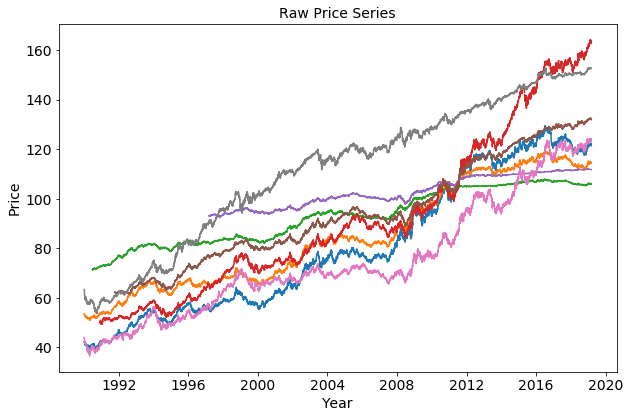

In [24]:
# Lets plot the data
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6.4))
plt.plot(price_data)
plt.ylabel('Price',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Raw Price Series',fontsize=14)
plt.show()


# Momentum Signal Definitions

The momentum signal for some asset $i$ is here defined as the simple average of scaled individual signals. The process of computing the scaled signals begins by first computing raw unscaled signals. These unscaled signals are then scaled using some normalization method.

# Signal 1:

The first signal that we test is simple average of realized Sharpe ratios. Each individual raw unscaled signal, $\tilde{s}_{i,w}(t)$, for asset $i$ and lookback $w$ is computed as the ratio of average of lagged $w$ returns, $\mu_{i,w}(t)$, divided by the standard deviation $\sigma(\mu_{i,w})(t)$. The average of lagged returns is:

$$\mu_{i,w}(t)=\frac{1}{w}\sum_{j=0}^{w}r_{i,t-j}$$

The problem with the raw signals $\mu_{i,w}(t)$ are that they have different variances and therefore they have different contributions to the final signal. In order to mitigate this problem we need to scale them to have similar variances. In the case of our first signal, the scaled signal is obtained by dividing the raw signal by its own 1250 day (approx. 5 trading years) standard deviation $\sigma_{1250}(\mu_{i,w})$, i.e.:

$$\tilde{s}_{i,w}(t)=Max\left(-1;Min\left(1;\frac{\mu_{i,w}(t)}{\sigma_{1250}(\mu_{i,w})(t)}\right)\right)$$

Additionally, we impose limits to the magnitude of signal such that $s_{i,w}(t) \in \left[ -1,1\right]$ to prohibit excessive positions. The final trading signal is then obtained by averaging the raw signals for each $w$:

$$s_i(t)=\sum_{j=1}^{3}s_{i,w_j}(t)$$


# Signal 2:
 
The second signal is computed like Signal 1 but we impose extra cutoff level of $\xi$. This truncates the signal to zero if the magnitude of the signal is not high enough.

$$s_{w}(t)=\left\{\begin{matrix}
s_{w}(t), \left | s_{w}(t) \right | \geq \xi \\ 
0
\end{matrix}\right.$$


# Lookback Windows:

For all signals we use a set of lookback windows, $w$, which define the length of data vectors. Here we use $w = \{ 66,132,250\}$
 

In [25]:
def signal_1(symbol,returns,return_lookback_windows,sigma_lookback_window):
    t = {}
    for w in return_lookback_windows:
        mu = returns.rolling(w).mean()
        s  = (mu.div(mu.rolling(sigma_lookback_window).std())).clip(-1,1)
        t.update({w:s.copy()})
    df = pd.DataFrame.from_dict(t,orient='columns').mean(axis=1)
    df.columns = [symbol]
    return df
    
def signal_2(symbol,returns,return_lookback_windows,sigma_lookback_window,cutoff):
    s_2 = signal_1(symbol,returns,return_lookback_windows,sigma_lookback_window)
    s_2[abs(s_2)<cutoff] = 0
    return s_2


def signal_3(symbol,price_data,return_lookback_windows,sigma_lookback_window):
    t = {}
    for w in return_lookback_windows:
        r_w   = price_data.pct_change(w)
        sigma = r_w.rolling(sigma_lookback_window).std()
        s     = (r_w.div(sigma)).clip(-1,1)
        t.update({w:s.copy()})
    df = pd.DataFrame.from_dict(t,orient='columns').mean(axis=1)
    df.columns = [symbol]        
    return df

# Return computation
ret = price_data.pct_change(1)

lookback_windows = [63,126,252]

# We allocate dictionary for the signal dataframes
momentum_signals = {}

# Signal 1
t = {}
for symbol in symbols:
    t.update({symbol:signal_1(symbol,ret[symbol],lookback_windows,1250)})
momentum_signals.update({"Signal_1":t})

# Signal 2
t = {}
for symbol in symbols:
    t.update({symbol:signal_2(symbol,ret[symbol],lookback_windows,1250,0.65)})
momentum_signals.update({"Signal_2":t})
    
# Signal 3 (Note: we pass price data here - not returns)
t = {}
for symbol in symbols:
    t.update({symbol:signal_3(symbol,price_data[symbol],lookback_windows,1250)})
momentum_signals.update({"Signal_3":t})


Lets plot the signals for sanity checking ....

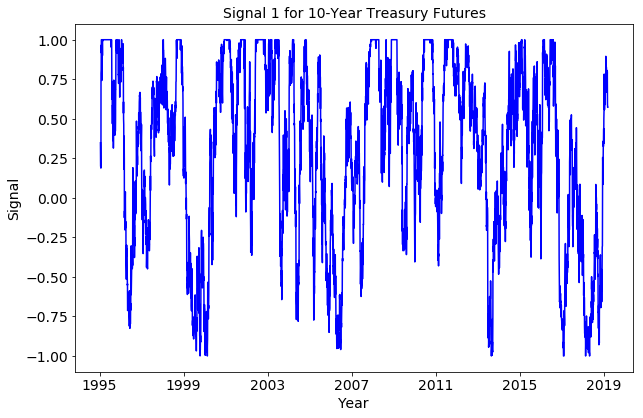

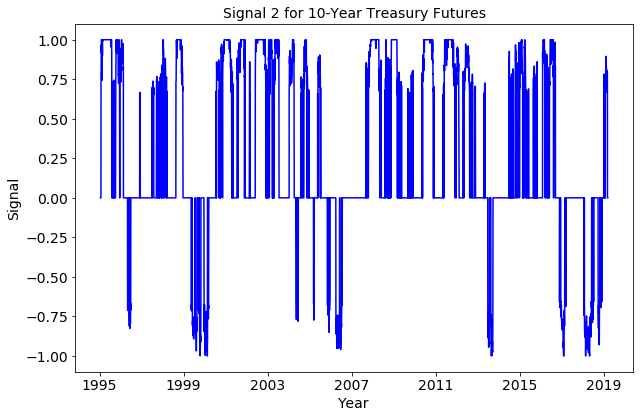

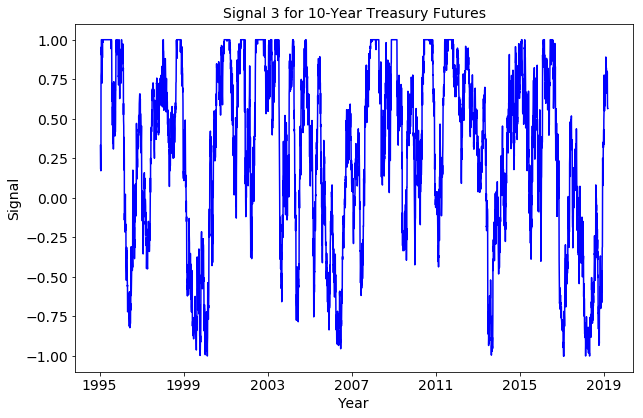

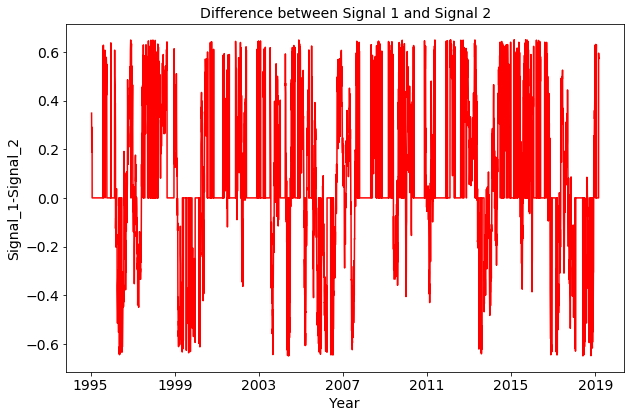

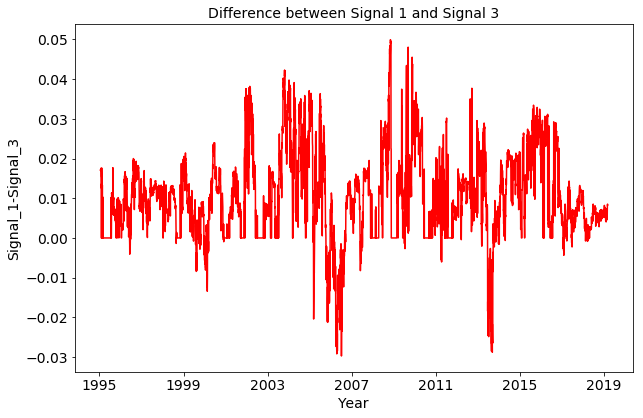

In [26]:
def plot_signal(signal_name,symbol,caption):

    signal_data = pd.DataFrame.from_dict(momentum_signals[signal_name][symbol],orient='columns').dropna()

    fig = plt.figure(figsize=(10,6.4))
    plt.plot(signal_data,color='blue')
    plt.ylabel('Signal',fontsize=14)
    plt.xlabel('Year',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f'{caption}',fontsize=14)
    plt.show()

def plot_signal_difference(signal_name_1,signal_name_2,symbol,caption):
    
    s_1 = pd.DataFrame.from_dict(momentum_signals[signal_name_1][symbol],orient='columns').dropna()
    s_2 = pd.DataFrame.from_dict(momentum_signals[signal_name_2][symbol],orient='columns').dropna()
    
    difference = s_1 - s_2
    
    fig = plt.figure(figsize=(10,6.4))
    plt.plot(difference,color='red')
    plt.ylabel(f'{signal_name_1}-{signal_name_2}',fontsize=14)
    plt.xlabel('Year',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f'{caption}',fontsize=14)
    plt.show()    
    
    
plot_signal("Signal_1","TY1 Comdty","Signal 1 for 10-Year Treasury Futures")
plot_signal("Signal_2","TY1 Comdty","Signal 2 for 10-Year Treasury Futures")
plot_signal("Signal_3","TY1 Comdty","Signal 3 for 10-Year Treasury Futures")    

plot_signal_difference("Signal_1","Signal_2","TY1 Comdty","Difference between Signal 1 and Signal 2")
plot_signal_difference("Signal_1","Signal_3","TY1 Comdty","Difference between Signal 1 and Signal 3")




# Volatility Scaling:
The next thing we need is the volatility scaling mechanism. The idea behind this is that since the time-series for volatility have strong auto-correlation then it is possible to create locally constant volatility time series using a clever weighting scheme:

$$L_{\sigma}(t)=Min\left[ Cap; \frac{\sigma_T}{\sigma_R(t)} \right]$$

where $\sigma_T$ is our target volatility which is here set to 10\% p.a. and $\sigma_R$ is the realized volatility in annualized terms. Here we use 63 window to calculate the realized volatility. However, the window can be anything you want. The term $Cap$ is the maximum leverage cap we impose to our volatility imposed leverage. Here se set $Cap=1$. However, this cap can be anything you want.


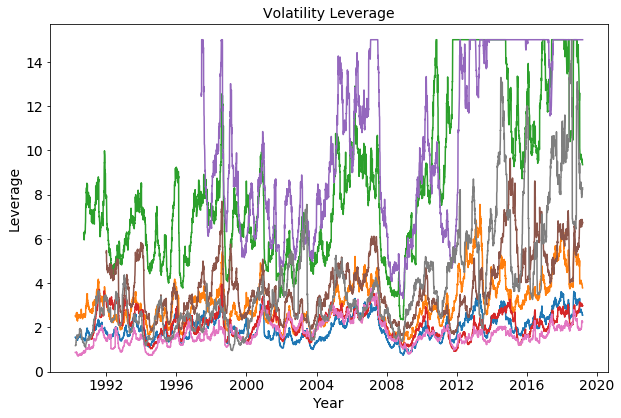

In [27]:
# Target volatility (per annum)
target_volatility = 0.10

# volatility window
sigma_window = 63

# Lets compute the volatility leverages for each individual underlying
L_sigmas = {}
for k,v in index_specifications.items():
    symbol        = index_specifications[k]['Symbol']
    vol_scale_cap = index_specifications[k]['Vol_Scale_Cap']
    L_sigma       = target_volatility/(ret[symbol].rolling(sigma_window).std().dropna()*np.sqrt(250))
    L_sigma       = L_sigma.clip(0,vol_scale_cap)
    L_sigmas.update({symbol:L_sigma})
L_sigmas = pd.DataFrame.from_dict(L_sigmas,orient='columns')
    
fig = plt.figure(figsize=(10,6.4))
plt.plot(L_sigmas)
plt.ylabel('Leverage',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'Volatility Leverage',fontsize=14)
plt.show()



# Backtesting Methodology:





# Nominal exposure from signal:
Now we are ready to compute the historical backtest of the strategy. Here the position is determined by the product of trading signal and the volatility leverage. That is, the total exposure in asset $i$ at time $t$, $E_{i}(t)$ is defined as:

$$E_{i}(t):=L_{i,\sigma}(t)s_i(t)$$

# Monthly rebalancing:

Here we use $\textit{monthly rebalancing}$, and therefore, we need to resample the daily trading signal on a monthly basis. More specifically, we create a set of rebalancing dates $\{t^{*}\}$. Then we take the signals for these dates $s_i(\{t^{*}\})$. The effective signal is then the signal from the immdetiately previous rebalancing date. Concretely, the effective signal, $s_i^{E}(t)$ series is:

$$s_i^{E}(t) = \left \{ s_i(t_1^{*}),\cdots ,s_i(t_1^{*}),s_i(t_2^{*}),\cdots ,s_i(t_2^{*}),\cdots,s_i(t_N^{*}),\cdots ,s_i(t_N^{*})  \right \}$$

where $t_1^{*}$ is the first rebalancing date and $t_N^{*}$ is the last rebalancing date. We compute the effective volatility leverage, $L_{i,\sigma}^{E}(t)$ using the same rebalancing dates and apply similar sparse sampling logic.

The monthly rebalanced exposure to asset $i$ at time $t$ is then given by:

$$E_{i}^{E}(t)=L_{i,\sigma}^{E}(t)s_i^{E}(t)$$

# Return computation:

Then the return on the position is computed using the effective exposure:

$$r_{i}(t) = E_{i}^{E}(t-1)r_i^{F}(t) $$

where $r_i^{F}(t)$ is the futures contract return.


# Signal 1 Performance

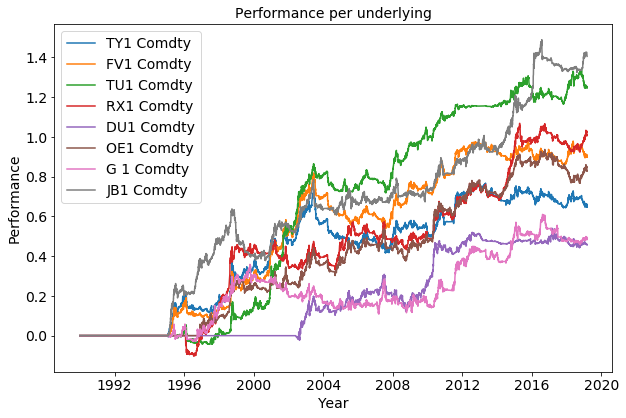

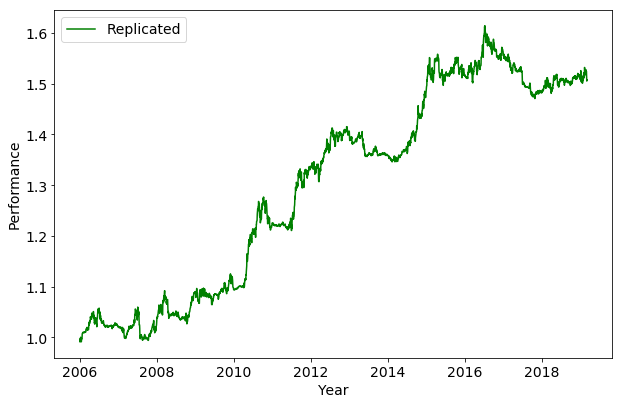

In [28]:
# Compute strategy returns using Signal 1
tested_signal_name = "Signal_1"
performances = {}
for signal_type,signal_data in momentum_signals.items():
    performance = {}
    for symbol in signal_data.keys():
        s           = pd.DataFrame.from_dict(momentum_signals[tested_signal_name][symbol]).mean(axis=1)
        rebal_dates = pd.date_range(start_date,end_date,freq='M')
        s_at_rebal  = s.loc[rebal_dates]
        l_at_rebal  = L_sigmas[symbol].loc[rebal_dates]
        
        effective_signal = s_at_rebal.reindex(s.index).fillna(method='ffill')
        effective_lever  = l_at_rebal.reindex(s.index).fillna(method='ffill')
        
        exposure = (effective_lever.shift(1)*effective_signal.shift(1)).fillna(0)
        returns  = ret[symbol]*exposure
        returns.columns = [symbol]
        performance.update({symbol:returns.copy()})
    performances.update({signal_type:performance})

signal_1_performance = pd.DataFrame.from_dict(performances[tested_signal_name],orient='columns').fillna(0)
        

fig_size  = (10,6.4)
font_size = 14

fig = plt.figure(figsize=fig_size)
for symbol in signal_1_performance.columns:
    plt.plot(signal_1_performance[symbol].cumsum(),label = symbol)
plt.ylabel('Performance',fontsize = font_size)
plt.xlabel('Year'       ,fontsize = font_size)
plt.xticks(fontsize = font_size)
plt.yticks(fontsize = font_size)
plt.legend(fontsize = font_size)
plt.title(f'Performance per underlying',fontsize = font_size)
plt.show()

#benchmark_returns = benchmark_data['NMXCFIMU Index'].pct_change(1)
signal_1_returns  = signal_1_performance.loc[benchmark_returns.index].mean(axis=1)

#y_1 = np.cumprod(1+benchmark_returns)
y_2 = np.cumprod(1+signal_1_returns)


fig = plt.figure(figsize=fig_size)
#plt.plot(y_1, color = 'blue' , label = 'NMXCFIMU Index')
plt.plot(y_2, color = 'green', label = 'Replicated')
plt.ylabel('Performance',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)
#plt.title(f"NMEDMG3E Index VS {tested_signal_name}",fontsize=14)
plt.show()




# Signal 2 Performance

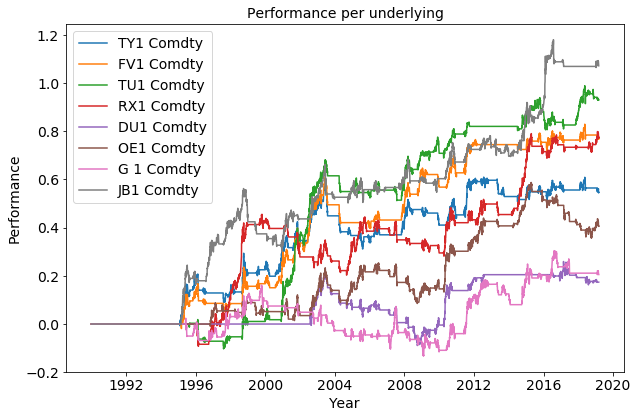

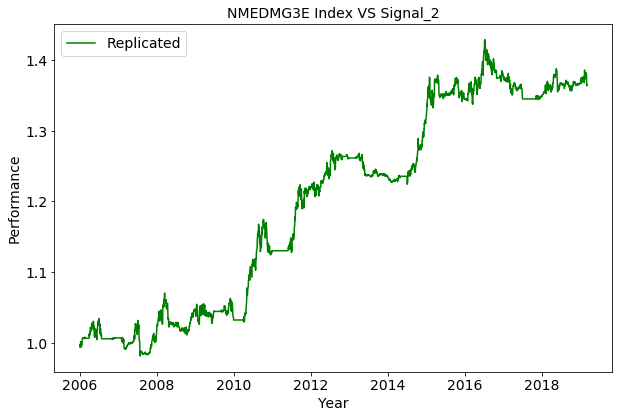

In [30]:
# Compute strategy returns using Signal 2
tested_signal_name = "Signal_2"
performances = {}
for signal_type,signal_data in momentum_signals.items():
    performance = {}
    for symbol in signal_data.keys():
        s           = pd.DataFrame.from_dict(momentum_signals[tested_signal_name][symbol]).mean(axis=1)
        rebal_dates = pd.date_range(start_date,end_date,freq='M')
        s_at_rebal  = s.loc[rebal_dates]
        l_at_rebal  = L_sigmas[symbol].loc[rebal_dates]
        
        effective_signal = s_at_rebal.reindex(s.index).fillna(method='ffill')
        effective_lever  = l_at_rebal.reindex(s.index).fillna(method='ffill')
        
        exposure = (effective_lever.shift(1)*effective_signal.shift(1)).fillna(0)
        returns  = ret[symbol]*exposure
        returns.columns = [symbol]
        performance.update({symbol:returns.copy()})
    performances.update({signal_type:performance})

signal_2_performance = pd.DataFrame.from_dict(performances[tested_signal_name],orient='columns').fillna(0)
        

fig_size  = (10,6.4)
font_size = 14

fig = plt.figure(figsize=fig_size)
for symbol in signal_2_performance.columns:
    plt.plot(signal_2_performance[symbol].cumsum(),label = symbol)
plt.ylabel('Performance',fontsize = font_size)
plt.xlabel('Year'       ,fontsize = font_size)
plt.xticks(fontsize = font_size)
plt.yticks(fontsize = font_size)
plt.legend(fontsize = font_size)
plt.title(f'Performance per underlying',fontsize = font_size)
plt.show()

benchmark_returns = benchmark_data['NMXCFIMU Index'].pct_change(1)
signal_2_returns  = signal_2_performance.loc[benchmark_returns.index].mean(axis=1)

y_1 = np.cumprod(1+benchmark_returns)
y_2 = np.cumprod(1+signal_2_returns)


fig = plt.figure(figsize=fig_size)
#plt.plot(y_1, color = 'blue' , label = 'NMXCFIMU Index')
plt.plot(y_2, color = 'green', label = 'Replicated')
plt.ylabel('Performance',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)
plt.title(f"NMEDMG3E Index VS {tested_signal_name}",fontsize=14)
plt.show()


# Signal 3 Performance

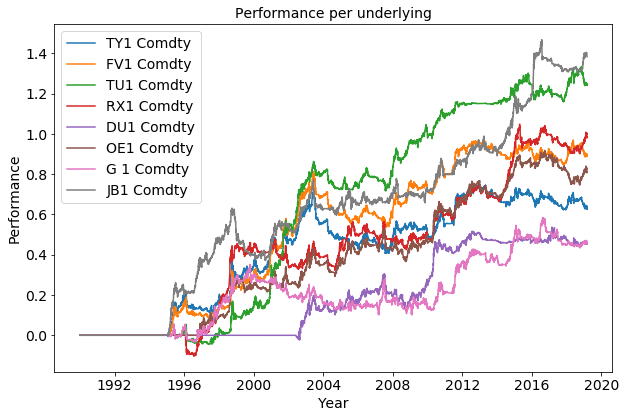

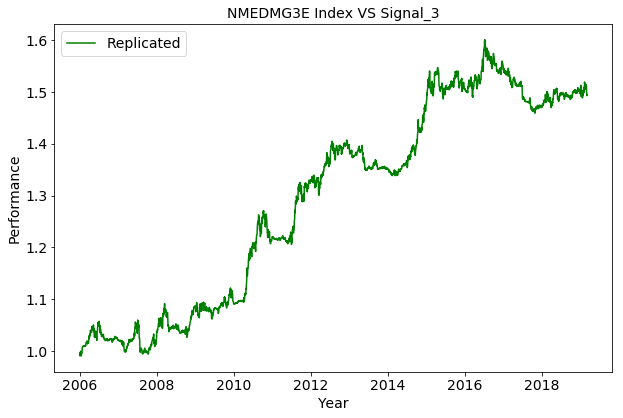

In [32]:
# Compute strategy returns using Signal 3
tested_signal_name = "Signal_3"
performances = {}
for signal_type,signal_data in momentum_signals.items():
    performance = {}
    for symbol in signal_data.keys():
        s           = pd.DataFrame.from_dict(momentum_signals[tested_signal_name][symbol]).mean(axis=1)
        rebal_dates = pd.date_range(start_date,end_date,freq='M')
        s_at_rebal  = s.loc[rebal_dates]
        l_at_rebal  = L_sigmas[symbol].loc[rebal_dates]
        
        effective_signal = s_at_rebal.reindex(s.index).fillna(method='ffill')
        effective_lever  = l_at_rebal.reindex(s.index).fillna(method='ffill')
        
        exposure = (effective_lever.shift(1)*effective_signal.shift(1)).fillna(0)
        returns  = ret[symbol]*exposure
        returns.columns = [symbol]
        performance.update({symbol:returns.copy()})
    performances.update({signal_type:performance})

signal_3_performance = pd.DataFrame.from_dict(performances[tested_signal_name],orient='columns').fillna(0)
        

fig_size  = (10,6.4)
font_size = 14

fig = plt.figure(figsize=fig_size)
for symbol in signal_3_performance.columns:
    plt.plot(signal_3_performance[symbol].cumsum(),label = symbol)
plt.ylabel('Performance',fontsize = font_size)
plt.xlabel('Year'       ,fontsize = font_size)
plt.xticks(fontsize = font_size)
plt.yticks(fontsize = font_size)
plt.legend(fontsize = font_size)
plt.title(f'Performance per underlying',fontsize = font_size)
plt.show()

benchmark_returns = benchmark_data['NMXCFIMU Index'].pct_change(1)
signal_3_returns  = signal_3_performance.loc[benchmark_returns.index].mean(axis=1)

y_1 = np.cumprod(1+benchmark_returns)
y_2 = np.cumprod(1+signal_3_returns)


fig = plt.figure(figsize=fig_size)
#plt.plot(y_1, color = 'blue' , label = 'NMXCFIMU Index')
plt.plot(y_2, color = 'green', label = 'Replicated')
plt.ylabel('Performance',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)
plt.title(f"NMEDMG3E Index VS {tested_signal_name}",fontsize=14)
plt.show()


# Performance Statistics

In [33]:
from scipy.stats import skew,kurtosis

def compute_statistics(returns):

    # For maximum drawdown we need compounded return series (not strictly correct but hey whatever)
    xs = (1.0 + returns).cumprod()
    
    start_date = xs.head(1).index[0]
    end_date   = xs.tail(1).index[0]
    years      = (end_date - start_date).days/365
    
    # Sample mean
    mu_avg  = returns.mean()*252
    
    # Cumulative aggregate growth rate
    mu_cagr = (xs.tail(1).values[0]/xs.head(1).values[0])**(1.0/years)-1.0
    
    # End of maximum drawdown
    i       = np.argmax(np.maximum.accumulate(xs) - xs) 
    
    # Start of maximum drawdown
    j       = np.argmax(xs[:i])
    
    # Magnitude of maximum drawdown
    max_dd  = (xs[i] - xs[j])/xs[j]
    
    # Volatility of the returns
    vol     = returns.std()*np.sqrt(250)
     
    # Sharpe ratio    
    sharpe  = mu_cagr/vol
    
    result = {}
    
    result.update({'Average_return' :round(100.0*mu_avg ,2) })
    result.update({'CAGR'           :round(100.0*mu_cagr,2) })
    result.update({'Volatility'     :round(100.0*vol,2)     })
    result.update({'Sharpe'         :round(mu_cagr/vol,2)   })
    result.update({'MaxDD'          :round(100.0*max_dd,2)  })
    result.update({'CalmarRatioAvg' :round(mu_avg  / abs(max_dd),3) })
    result.update({'CalmarRatioCAGR':round(mu_cagr / abs(max_dd),3) })
    result.update({'MaxDDperVol'    :round(max_dd/vol,2)               })
    result.update({'Skew'           :round(skew(xs),2)                 })
    result.update({'ExcessKurtosis' :round(kurtosis(xs,fisher=True),2) })
    
    return result


In [36]:
signal_1_statistics  = compute_statistics(signal_1_returns.dropna())
signal_2_statistics  = compute_statistics(signal_2_returns.dropna())
signal_3_statistics  = compute_statistics(signal_3_returns.dropna())
#benchmark_statistics = compute_statistics(benchmark_returns.dropna())


df_1  = pd.DataFrame.from_dict(signal_1_statistics  , orient='index', columns=['Signal 1'])
df_2  = pd.DataFrame.from_dict(signal_2_statistics  , orient='index', columns=['Signal 2'])
df_3  = pd.DataFrame.from_dict(signal_3_statistics  , orient='index', columns=['Signal 3'])
#df_bm = pd.DataFrame.from_dict(benchmark_statistics , orient='index', columns=['NMEDMG3E Index'])

summary = pd.concat([df_1,df_2,df_3],axis=1)

print(summary)

                 Signal 1  Signal 2  Signal 3  NMEDMG3E Index
Average_return      3.210     2.430     3.150           4.950
CAGR                3.190     2.410     3.120           4.970
Volatility          4.590     3.870     4.550           4.880
Sharpe              0.690     0.620     0.690           1.020
MaxDD              -8.900    -5.930    -8.850          -7.440
CalmarRatioAvg      0.361     0.410     0.355           0.665
CalmarRatioCAGR     0.359     0.407     0.353           0.668
MaxDDperVol        -1.940    -1.530    -1.940          -1.520
Skew               -0.200    -0.130    -0.210          -0.440
ExcessKurtosis     -1.500    -1.530    -1.500          -1.310
